#1#**MSD** Correlation one datathon


In [1]:
!pip install catboost --quiet

In [5]:
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import f1_score
from progressbar import progressbar 

In [9]:
df = pd.read_csv("/content/drive/MyDrive/Datathon/Datasets/treatments_2017-2020.csv")

In [8]:
facilities = pd.read_csv("/content/drive/MyDrive/Datathon/Datasets/treatment_facilities_2016_2020.csv",low_memory=False)

In [12]:
substances = {-9 : "Missing/unknown/not collected/invalid",
              1 : 'None',
              2 : "Alcohol",
              3 : "Cocaine/crack",
              4 : "Marijuana/hashish",
              5 : "Heroin",
              6 : "Non-prescription methadone",
              7 : "Other opiates and synthetics",
              8 : "PCP",
              9 : "Hallucinogens",
              10 : "Methamphetamine/speed",
              11 : "Other amphetamines",
              12 : "Other stimulants",
              13 : "Benzodiazepines",
              14 : "Other tranquilizers",
              15 : "Barbiturates",
              16 : "Other sedatives or hypnotics",
              17 : "Inhalants",
              18 : "Over-the-counter medications",
              19 : "Other drugs",
              }
df[['SUB1','SUB2','SUB3']] = df[['SUB1','SUB2','SUB3']].apply(lambda x:x.apply(lambda y:substances[y]))


#Decoding States

In [10]:
a = """
Alabama	01	AL
Alaska	02	AK
Arizona	04	AZ
Arkansas	05	AR
California	06	CA
Colorado	08	CO
Connecticut	09	CT
Delaware	10	DE
District of Columbia	11	DC
Florida	12	FL
Georgia	13	GA
Hawaii	15	HI
Idaho	16	ID
Illinois	17	IL
Indiana	18	IN
Iowa	19	IA
Kansas	20	KS
Kentucky	21	KY
Louisiana	22	LA
Maine	23	ME
Maryland	24	MD
Massachusetts	25	MA
Michigan	26	MI
Minnesota	27	MN
Mississippi	28	MS
Missouri	29	MO
Montana	30	MT
Nebraska	31	NE
Nevada	32	NV
New Hampshire	33	NH
New Jersey	34	NJ
New Mexico	35	NM
New York	36	NY
North Carolina	37	NC
North Dakota	38	ND
Ohio	39	OH
Oklahoma	40	OK
Oregon	41	OR
Pennsylvania	42	PA
Rhode Island	44	RI
South Carolina	45	SC
South Dakota	46	SD
Tennessee	47	TN
Texas	48	TX
Utah	49	UT
Vermont	50	VT
Virginia	51	VA
Washington	53	WA
West Virginia	54	WV
Wisconsin	55	WI
Wyoming	56	WY
American Samoa	60	AS	
Federated States of Micronesia	64	FM	
Guam	66	GU	
Marshall Islands	68	MH	
Commonwealth of the Northern Mariana Islands	69	MP	
Palau	70	PW	
Puerto Rico	72	PR	
U.S. Minor Outlying Islands	74	UM	
U.S. Virgin Islands	78	VI	
Baker Island	81 LO
Howland Island	84 La
Jarvis Island	86 SS
Johnston Atoll	67 LO
Kingman Reef	89 KK
Midway Islands	71 LO
Navassa Island	76 AS
Palmyra Atoll	95 AS
Wake Island	79 ds
"""
map = {}
for ind,i in enumerate(a.split('\n')):
    if ind==0:
      continue
    _ = i.split()
    try:
      code,state = int(_[-2]),' '.join(_[0:-2])
    except Exception as e:
      print(e,_)
    map[code]=state
df.STFIPS = df.STFIPS.apply(lambda x:map[x])
f_map = {}
for ind,i in enumerate(a.split('\n')):
    if ind==0:
      continue
    _ = i.split()
    try:
      code,state = _[-1],' '.join(_[0:-2])
    except Exception as e:
      print(e,_)
    f_map[code]=state
for i in facilities.STATE.unique():
  if i not in f_map.keys():
    f_map[i] = 'No information'
facilities.STATE = facilities.STATE.apply(lambda x:f_map[x])

list index out of range []
list index out of range []


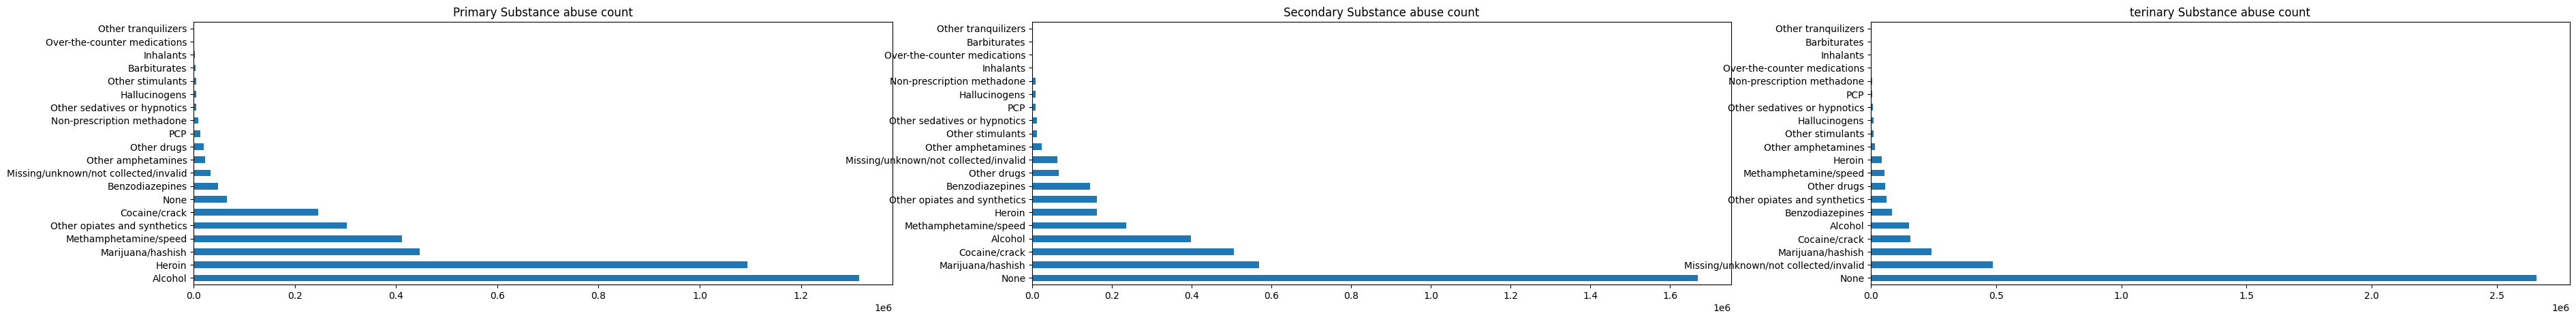

In [15]:
from matplotlib import pyplot as plt

fig,subplots = plt.subplots(1,3,figsize=(3*15,5))

df['SUB1'].value_counts().plot(kind ='barh',ax=subplots[0],title = 'Primary Substance abuse count')

df['SUB2'].value_counts().plot(kind ='barh',ax=subplots[1],title = 'Secondary Substance abuse count')

df['SUB3'].value_counts().plot(kind ='barh',ax=subplots[2],title = 'terinary Substance abuse count')

plt.show()


# Secondary substance abuse was more None than other substances

# Death Rate 
    per substance over total substance cases

<Axes: ylabel='SUB1'>

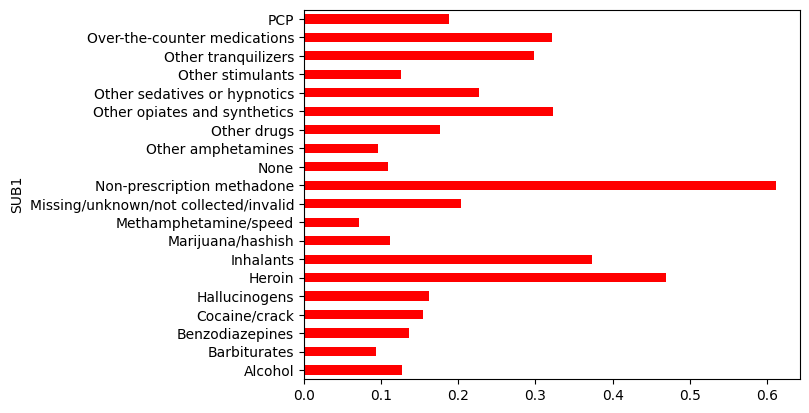

In [5]:
total_deaths = df[df['REASON']==6].shape[0]
df.groupby('SUB1').apply(lambda x: x[x["REASON"]==6].shape[0]*100/x.shape[0]).plot(kind = 'barh',color='r')


# Death rate for substances
    per substance over total deaths 

<Axes: ylabel='SUB1'>

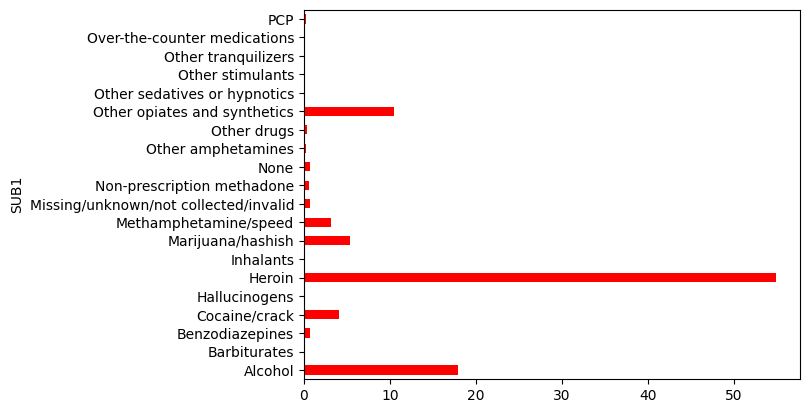

In [8]:
df.groupby('SUB1').apply(lambda x: x[x["REASON"]==6].shape[0]*100/total_deaths[0]).plot(kind = 'barh',color='r')

Heroin is deadliest

# Treatment completion rate by substance

<Axes: title={'center': 'Treatment completion rate per substance'}, ylabel='SUB1'>

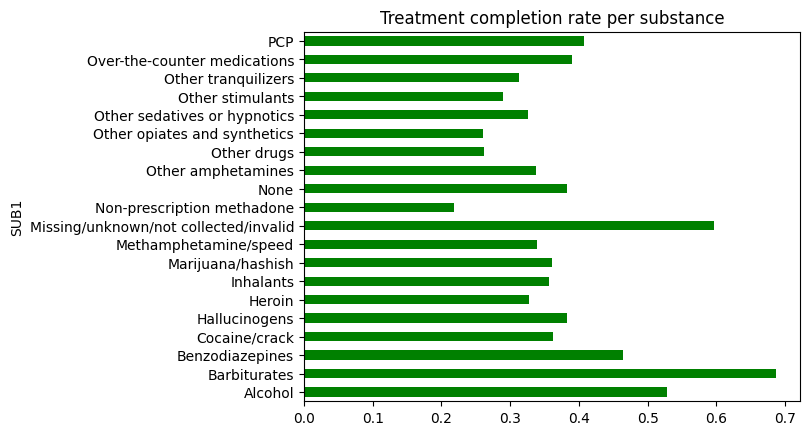

In [10]:
df.groupby('SUB1').apply(lambda x: x[x["REASON"]==1].shape[0]/x.shape[0]).plot(kind='barh',
                                                                               color='g',
                                                                               title='Treatment completion rate per substance')

#Factors affecting each substance

Data cleaning

[----------------------------------------------------------------------------------------------->.....] 
 


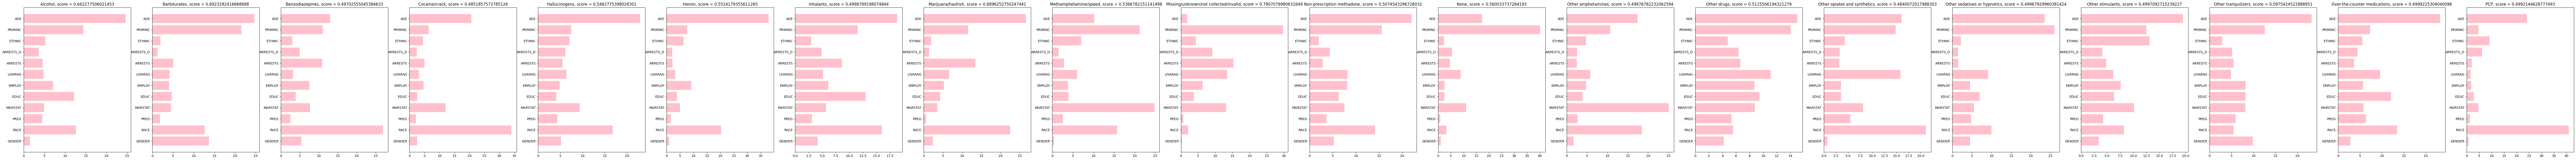

In [11]:


pb= progressbar(2)
def func(substance,ax):
    categorical_columns = ['GENDER','RACE','PREG','MARSTAT',
               'EDUC','EMPLOY','LIVARAG','ARRESTS','ARRESTS_D','ETHNIC','PRIMINC']
    data = df[categorical_columns+['AGE']]

    y = df['SUB1'].apply(lambda x:1 if x==f'{substance}' else 0) 
    
    X_train, X_test, y_train, y_test = train_test_split(data,
                                                        y, test_size=0.33, random_state=42)

    pool = Pool(data=X_train, label=y_train,cat_features=categorical_columns)

    model = CatBoostClassifier(verbose=False, task_type='GPU', devices='0')

    model.fit(pool)

    score = f1_score(model.predict(X_test), y_test,average='macro')

    ax.barh(X_train.columns,model.get_feature_importance(),color='pink')

    ax.set_title(f'{substance}, score = {score}')
    
    return ax

substances = df['SUB1'].value_counts().sort_index().keys()
fig , subplots = plt.subplots(1,len(substances),figsize=(7*len(substances),8))
plots=[]
for index,substance in enumerate(substances):
    pb.print(index,20)
    plots.append(func(substance,subplots[index]))

#Based on above Graphs one relation would be barbituerates which has high score for gender

#Exploring Barbiturates

<Axes: ylabel='STFIPS'>

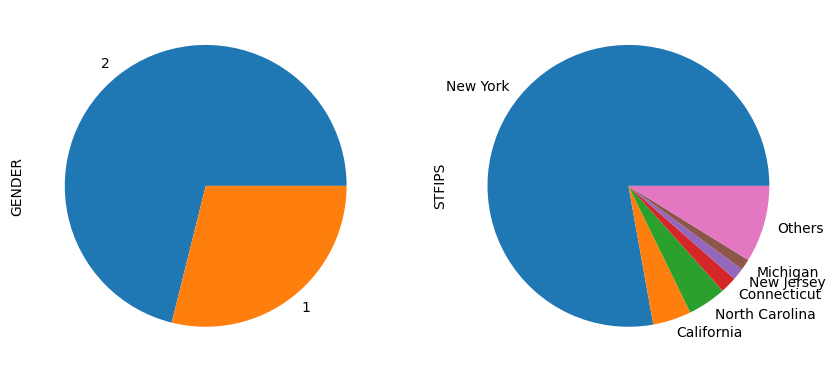

In [15]:
fig,subplots = plt.subplots(1,2,figsize=(10,5))
df[df['SUB1']=='Barbiturates']['GENDER'].value_counts().plot.pie(ax=subplots[0])
counts = df[df['SUB1']=='Barbiturates']['STFIPS'].value_counts()
others = sum(counts[6:])
counts = counts[:6]
counts['Others']=others
counts.plot.pie(ax=subplots[1])

Its more common into woman and

> its mainly New york based



In [10]:
df[df['SUB1']=='Barbiturates'].shape[0]

3220

#Since very few cases are available so Dead end

In [16]:
facilities['TREATMT'].value_counts()

1    73935
0      885
Name: TREATMT, dtype: int64

In [18]:
facilities[facilities['TREATMT']==0]['STATE'].value_counts().head(5)

New York          136
California         75
Florida            73
North Carolina     66
Illinois           37
Name: STATE, dtype: int64

In [19]:
state_wise_ = df.groupby('STFIPS').apply(lambda x:  pd.DataFrame({'Treatment completion rate':round(x[x['REASON']==1].shape[0]*100/x.shape[0],2),
                                                    'Total cases':x.shape[0]},index =[0])    )

In [20]:
state_wise_.reset_index(inplace=True)
state_wise_.drop('level_1',axis=1,inplace=True)
state_wise_.set_index('STFIPS',inplace=True)
state_wise_.sort_values('Treatment completion rate').head(10)

,Treatment completion rate,Total cases
STFIPS,,
Kentucky,5.87,163584
New Mexico,7.56,1494
Georgia,8.62,4108
Maryland,14.73,2438
North Carolina,17.75,465818
Louisiana,19.08,12064
Missouri,21.78,121303
Michigan,23.07,183536
Mississippi,24.11,12314


In [21]:
state_wise_.sort_values('Treatment completion rate',ascending =False).head(10)

,Treatment completion rate,Total cases
STFIPS,,
Arizona,98.66,12597
Colorado,74.84,104916
Nebraska,65.87,19126
South Dakota,64.88,42234
Arkansas,60.59,27396
District of Columbia,56.55,13623
New Jersey,55.43,271888
Texas,54.40,89492
Puerto Rico,54.24,8280


# worst performing state is kentucky and best performing considering numbers is colorado

<Axes: ylabel='SUB1'>

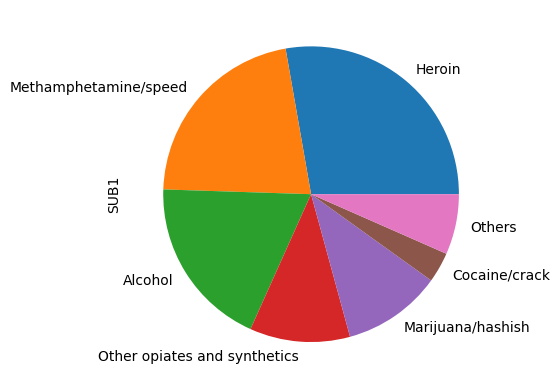

In [22]:
def aggregate(counts):
    
    others = sum(counts[6:])
    counts = counts[:6]
    counts['Others']=others
    return counts
aggregate(df[df['STFIPS']=='Kentucky']['SUB1'].value_counts()).plot.pie()

<Axes: ylabel='SUB1'>

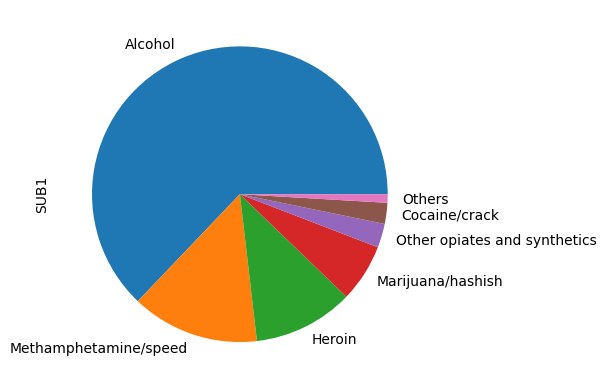

In [23]:
aggregate(df[df['STFIPS']=='Colorado']['SUB1'].value_counts()).plot.pie()

#digging into state wise substance wise

In [24]:
state_facilities = facilities.STATE.value_counts()
drugs_scpecific = df.groupby('STFIPS')
drugs_scpecific = drugs_scpecific.apply(lambda x:  pd.DataFrame(x['SUB1'].value_counts()).T)
drugs_scpecific.reset_index(inplace=True)
drugs_scpecific.drop('level_1',axis=1,inplace=True)
drugs_scpecific.set_index('STFIPS',inplace=True)
drugs_scpecific= drugs_scpecific.fillna(0)

In [25]:
drugs_scpecific.head()

,Marijuana/hashish,Alcohol,Methamphetamine/speed,Heroin,Other opiates and synthetics,Cocaine/crack,Benzodiazepines,Other drugs,Non-prescription methadone,Other stimulants,Other amphetamines,Missing/unknown/not collected/invalid,Other sedatives or hypnotics,Hallucinogens,Inhalants,Over-the-counter medications,Barbiturates,Other tranquilizers,None,PCP
STFIPS,,,,,,,,,,,,,,,,,,,,
Alabama,140,140,89.0,69,60,32.0,8.0,5.0,5.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alaska,943,5687,1486.0,2589,552,171.0,29.0,90.0,9.0,68.0,61.0,29.0,31.0,9.0,4.0,4.0,3.0,1.0,0.0,0.0
Arizona,425,1081,690.0,693,248,39.0,4.0,12.0,0.0,17.0,0.0,8756.0,1.0,4.0,1.0,0.0,0.0,0.0,626.0,0.0
Arkansas,5367,6756,8240.0,836,3143,1106.0,314.0,100.0,39.0,64.0,704.0,52.0,83.0,75.0,31.0,16.0,15.0,8.0,365.0,82.0
California,40847,91861,129273.0,114182,22146,13403.0,1450.0,1836.0,924.0,117.0,520.0,27.0,740.0,214.0,172.0,56.0,142.0,101.0,0.0,757.0


In [26]:
population = pd.read_csv('/content/drive/MyDrive/Datathon/Datasets/state_county_cbsa_population.csv')
population.head(5)

,Geographic Area Name,2010_population,2011_population,2012_population,2013_population,2014_population,2015_population,2016_population,2017_population,2018_population,2019_population
0,Alabama,"4,785,437","4,799,069","4,815,588","4,830,081","4,841,799","4,852,347","4,863,525","4,874,486","4,887,681","4,903,185"
1,Alaska,"713,910","722,128","730,443","737,068","736,283","737,498","741,456","739,700","735,139","731,545"
2,Arizona,"6,407,172","6,472,643","6,554,978","6,632,764","6,730,413","6,829,676","6,941,072","7,044,008","7,158,024","7,278,717"
3,Arkansas,"2,921,964","2,940,667","2,952,164","2,959,400","2,967,392","2,978,048","2,989,918","3,001,345","3,009,733","3,017,804"
4,California,"37,319,502","37,638,369","37,948,800","38,260,787","38,596,972","38,918,045","39,167,117","39,358,497","39,461,588","39,512,223"


In [27]:
population.set_index('Geographic Area Name',inplace = True)

For others Arkansas name is used for ease of code

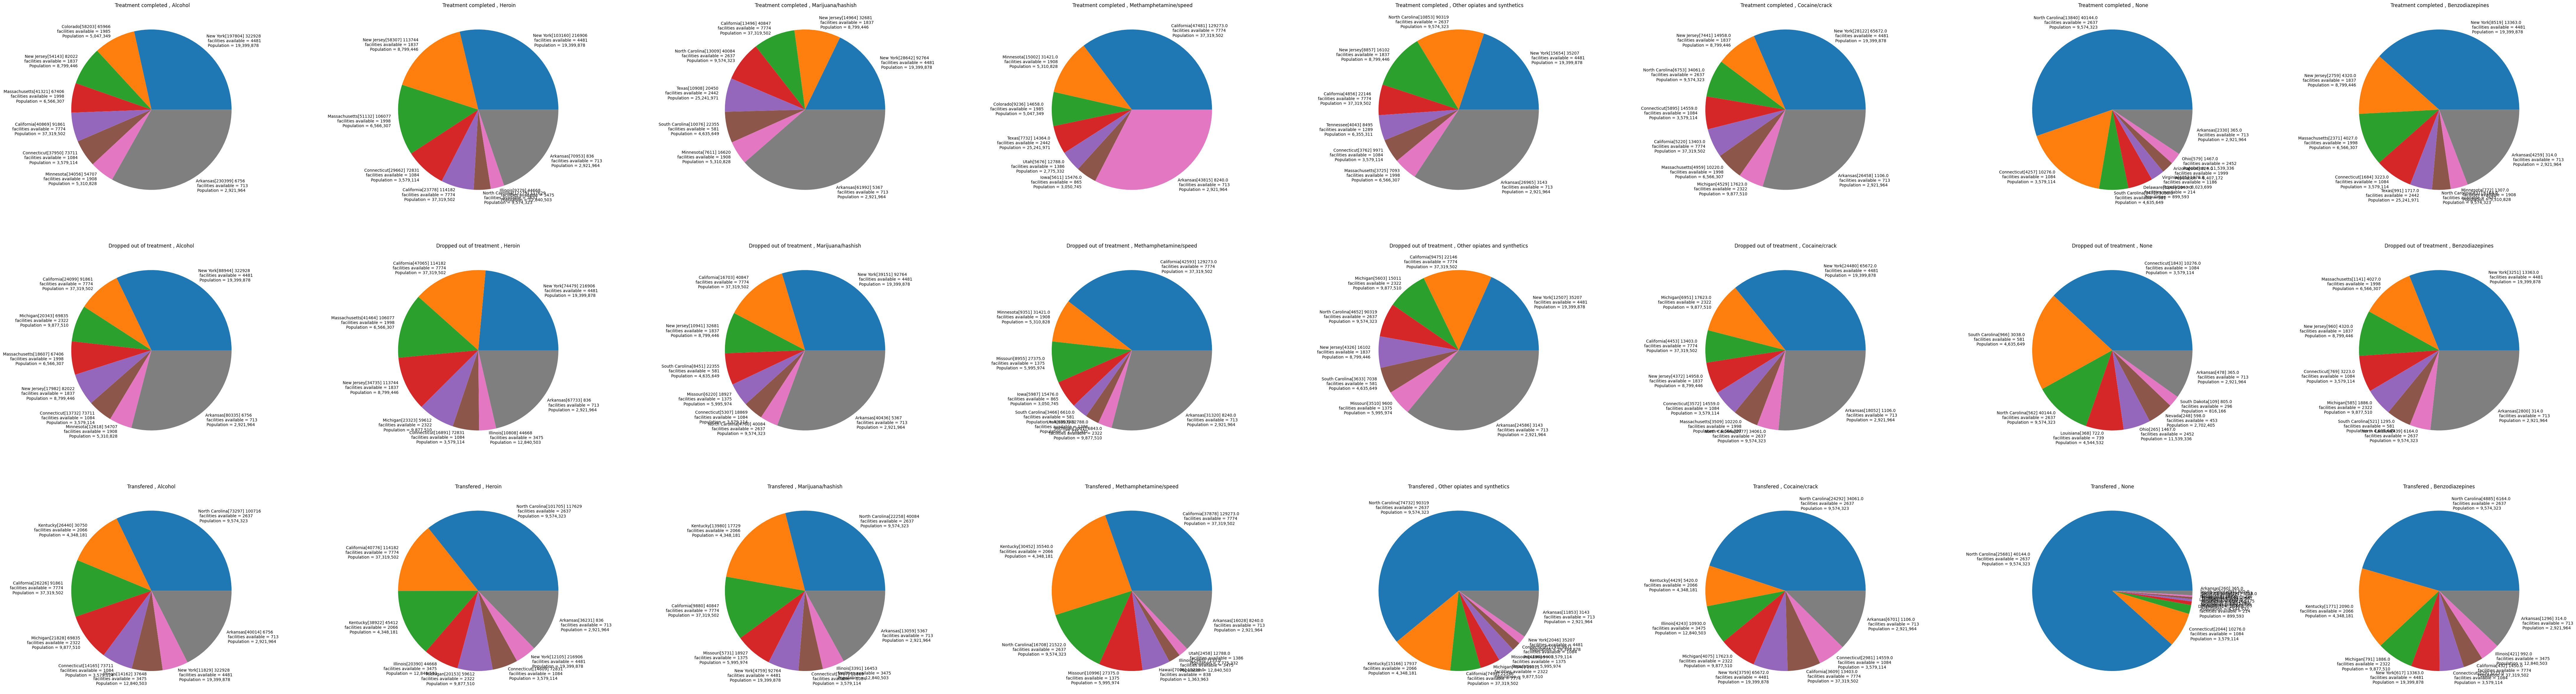

In [35]:
def func(x):

    return state_facilities[x]

groups = df.groupby(['REASON','SUB1'])
top_drugs = df['SUB1'].value_counts().sort_values(ascending=False).keys()[:8]
d = {1:' Treatment completed',2:'Dropped out of treatment',4:'Transfered'}
fig,subplots = plt.subplots(3,len(top_drugs),figsize=(len(top_drugs)*14,30))

for i_ind,i in enumerate([1,2,4]):
    
    for ind,j in enumerate(top_drugs):
        group = groups.get_group((i,j))
        counts = group['STFIPS'].value_counts().sort_values(ascending=False)
        summ = sum(counts[7:])
        counts = counts[:7]
        counts['Arkansas'] = summ
        subplots[i_ind][ind].pie(counts.values,
                          labels=[i+f'[{str(counts[i])}] {round(drugs_scpecific.loc[i,j] ,2)}\n facilities available = {func(i)}\n Population = {population.loc[i,"2010_population"]}' for i in counts.keys()])
        subplots[i_ind][ind].set_title(f'{d[i]} , {j}')
plt.show()

# Inferences after exploring above diagram



        







#1: - Kentucky is worst performing state in terms of treatment completion and all cases were transfered
#2: - North Carolina also same especially in other opiates and synthetics
#2: - Colorado is performing better so exploring Colorado further 


In [157]:
state_groups = df.groupby('STFIPS')
kentucky = state_groups.get_group('Kentucky')
north_carolina = state_groups.get_group('North Carolina')
Colorado = state_groups.get_group('Colorado')

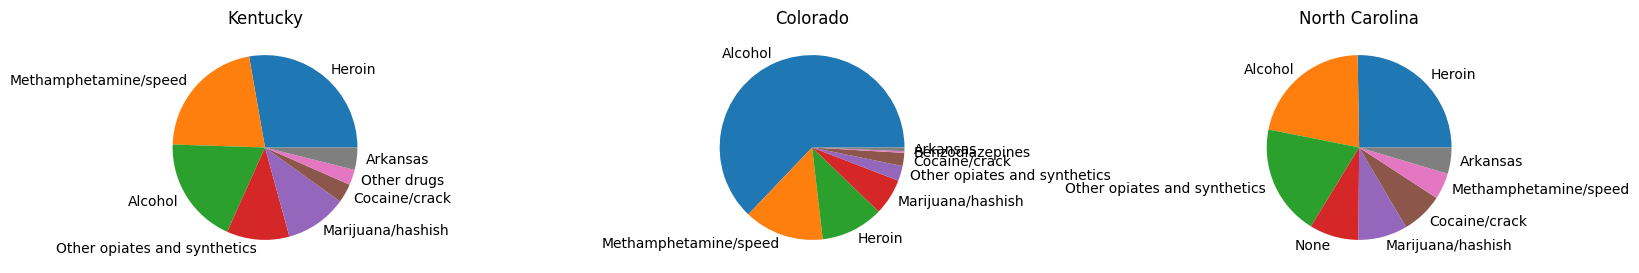

In [158]:
fig,subplots = plt.subplots(1,3,figsize=(20,3))

for index , state in enumerate(['Kentucky','Colorado','North Carolina']):
    counts = state_groups.get_group(state).SUB1.value_counts().sort_values(ascending=False)
    summ = sum(counts[7:])
    counts = counts[:7]
    counts['Arkansas'] = summ
    subplots[index].pie(counts,labels = counts.keys())
    subplots[index].set_title(state)
plt.show()


# Exploring Colorado more 

In [159]:

reason={1:'Treatment_completionrate',
        2:'Dropped out of treatment',
        3:'Terminated by facility',
        4:'Transfered to other facility',
        5:'incarerated',
        6:'Death',
        7:'Other',
        8:'Total'}
Colorado = Colorado.copy()
Colorado.REASON = Colorado.REASON.apply(lambda x:reason[x])

In [160]:
substance_wise_Colorado = Colorado.groupby('SUB1').apply(lambda x:pd.DataFrame(x['REASON'].value_counts()).T).reset_index().drop('level_1',axis=1).set_index('SUB1').fillna(0)

In [161]:
substance_wise_Colorado=substance_wise_Colorado.loc[substance_wise_Colorado.sum(axis=1).sort_values(ascending=False).index]

<Axes: xlabel='SUB1'>

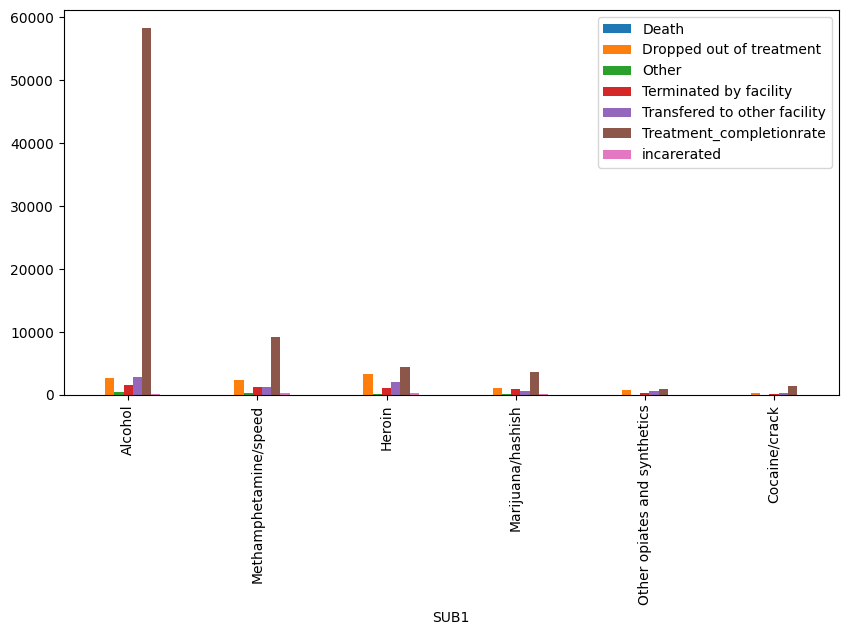

In [162]:
substance_wise_Colorado =substance_wise_Colorado.sort_index(axis=1)
substance_wise_Colorado.iloc[:6].plot.bar(figsize=(10,5),width=.5)

#Colorado is mainly focused on Alcohol 

Treatment completion rate is 88%


In [163]:
substance_wise_Colorado.loc['Alcohol',"Treatment_completionrate"]/substance_wise_Colorado.sum(axis=1)['Alcohol']

0.8823181639026165

#Looking for kentucky if its performing any better in any other substances

In [164]:
kentucky = kentucky.copy()
kentucky.REASON = kentucky.REASON.apply(lambda x:reason[x])

In [165]:
substance_wise_kentucky = kentucky.groupby('SUB1').apply(lambda x:pd.DataFrame(x['REASON'].value_counts()).T).reset_index().drop('level_1',axis=1).set_index('SUB1').fillna(0)

<Axes: xlabel='SUB1'>

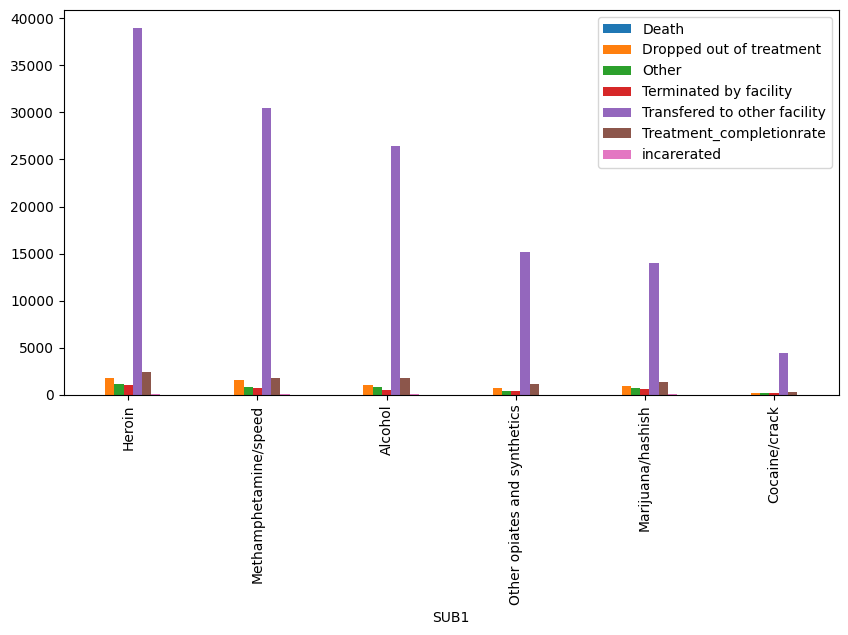

In [166]:
substance_wise_kentucky=substance_wise_kentucky.loc[substance_wise_kentucky.sum(axis=1).sort_values(ascending=False).index]
substance_wise_kentucky = substance_wise_kentucky.sort_index(axis=1)
substance_wise_kentucky.iloc[:6].plot.bar(figsize=(10,5))

# Transfer rate is very high